# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
import random

In [9]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

(195, 200, 3)
(195, 200, 3)


<IPython.core.display.Javascript object>


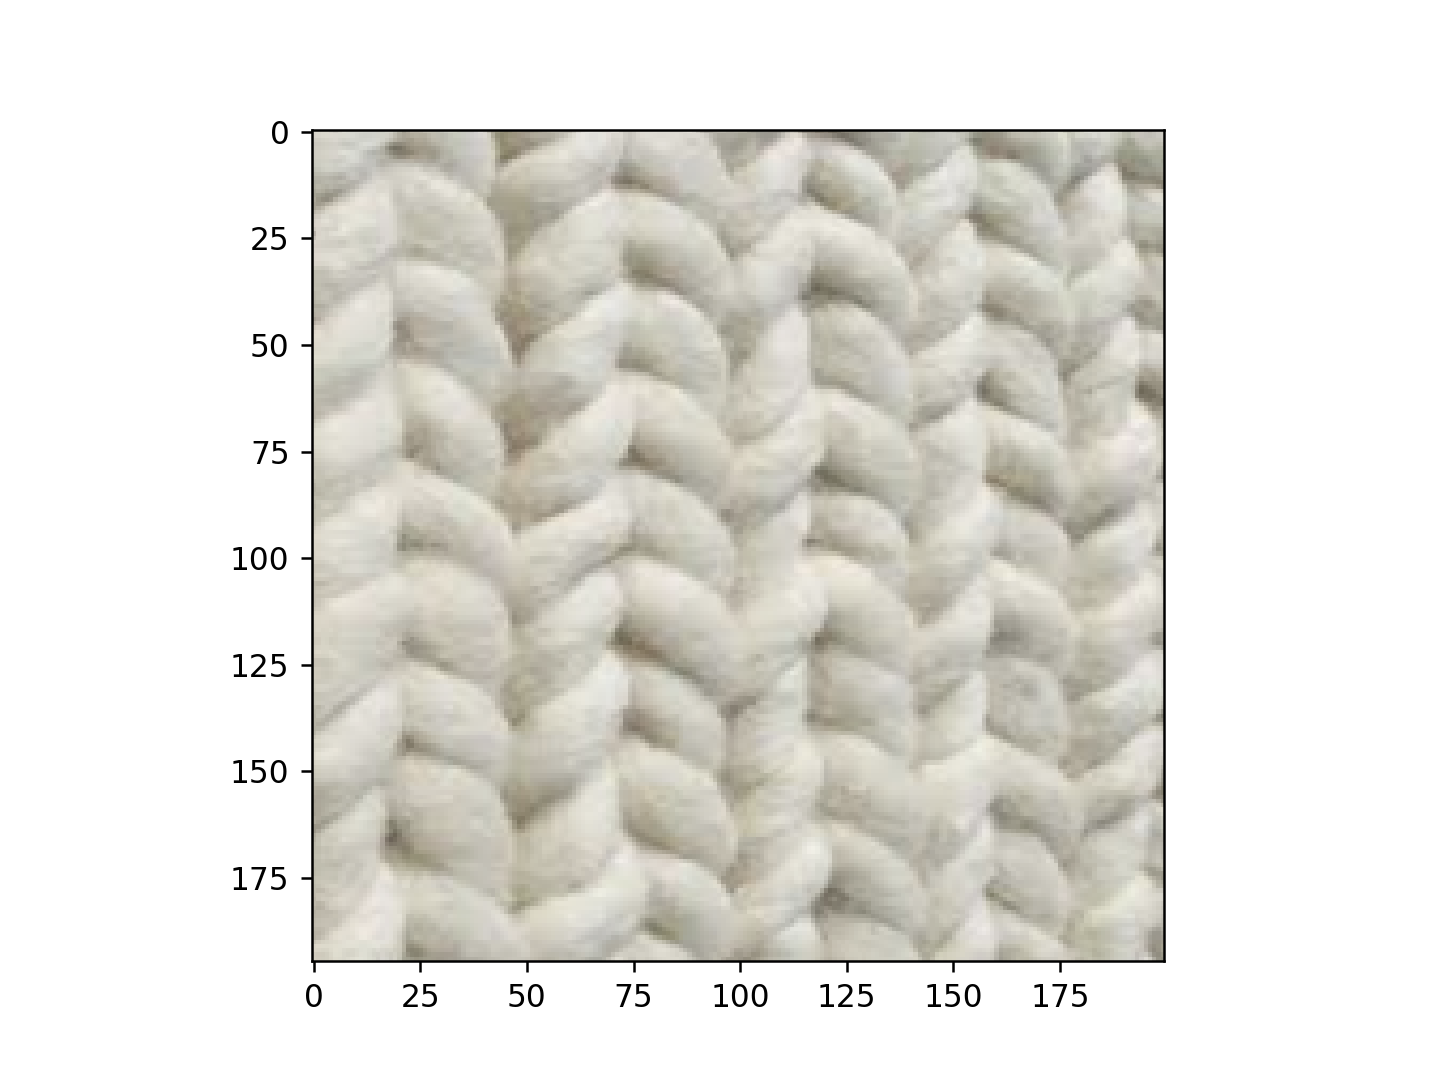

In [10]:
# sample_img_dir = 'samples/texture.png' # feel free to change
sample_img_dir = 'samples/texture.png'
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)/255
    target_img = cv2.imread("samples/feynman.tiff")/255
print(sample_img.shape)
sample_img.max()
sample_img = sample_img[:200, :200, :]
print(sample_img.shape)

def BGRtoRGB(img):
    x = np.zeros(img.shape, dtype=img.dtype)
    x[:,:,0] = img[:,:,2]
    x[:,:,1] = img[:,:,1]
    x[:,:,2] = img[:,:,0]
    return x
plt.imshow(BGRtoRGB(sample_img))


In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output_image = np.zeros((out_size, out_size, 3),dtype=sample.dtype)
    
    frame_size = int(out_size/patch_size)
    for j in range(0, frame_size):
        for i in range(0, frame_size):
            rand_row = random.randint(0, sample.shape[0] - patch_size - 1)
            rand_col = random.randint(0, sample.shape[1] - patch_size - 1)
            rand_patch = sample[rand_row : rand_row + patch_size, rand_col: rand_col + patch_size, :]
            plt.imshow(rand_patch)
            output_image[j*patch_size:j*patch_size + patch_size, i*patch_size : i*patch_size + patch_size, :] = rand_patch
    return output_image
    
     
  

<IPython.core.display.Javascript object>


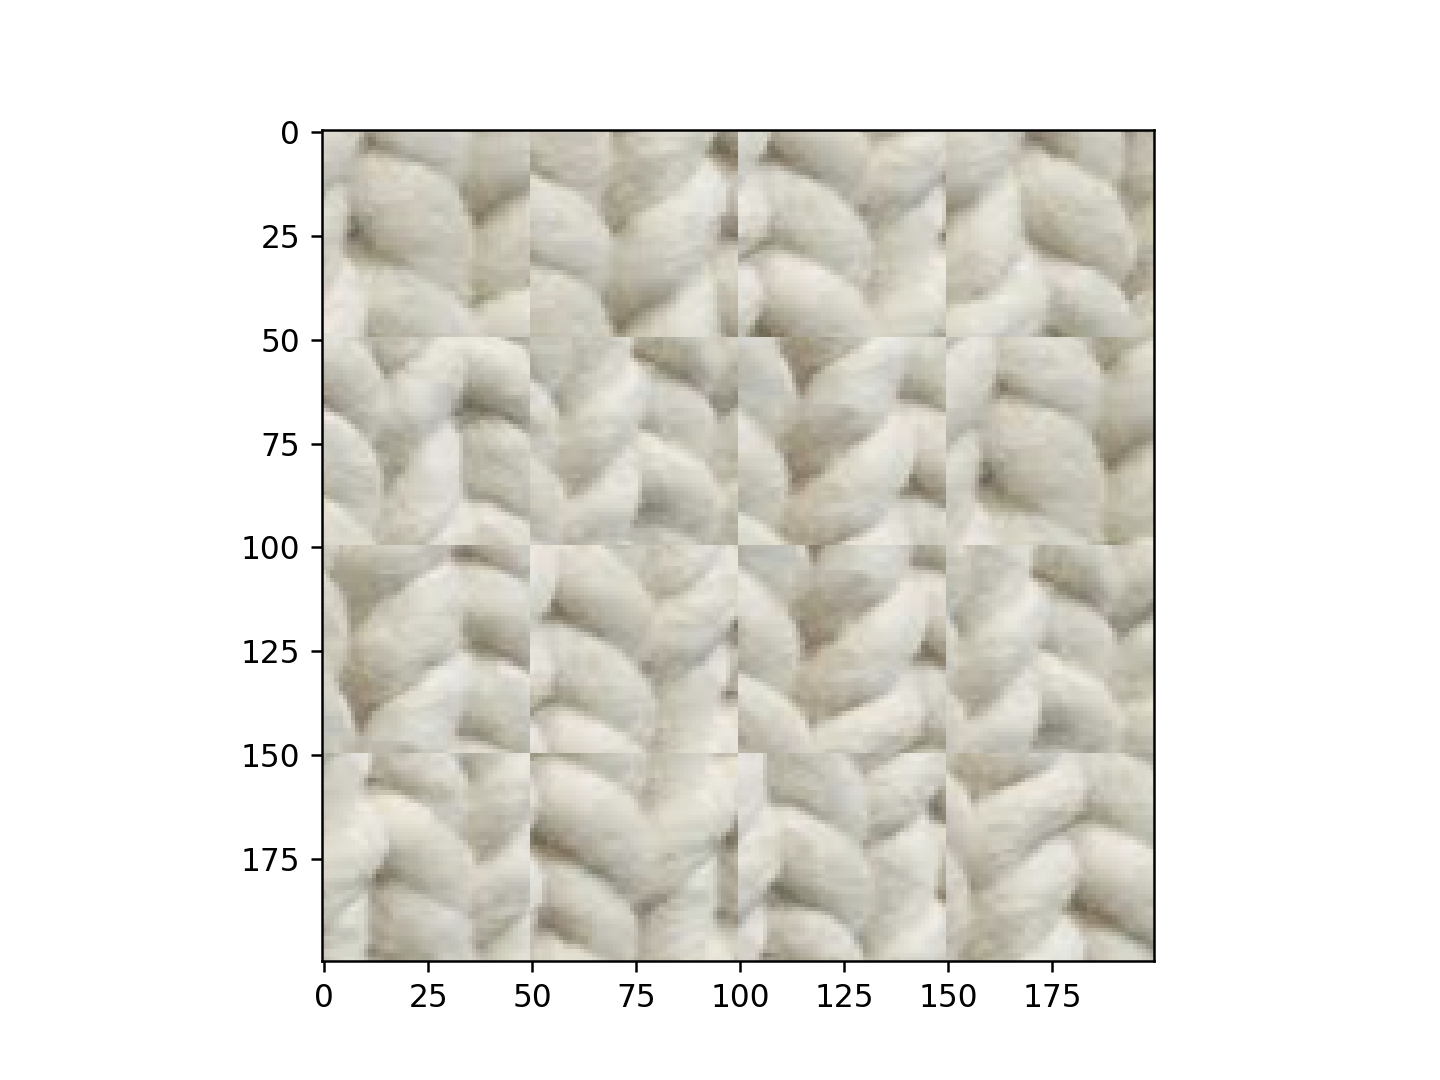

In [11]:
out_size = 200  # feel free to change to debug
patch_size = 50 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
# if res:

%matplotlib notebook
plt.imshow(BGRtoRGB(res))

### Part II: Overlapping Patches (30 pts)

In [12]:
def SSD_match(T, M, I, pre_computed):

    ssd =  - 2 * cv2.filter2D(I, ddepth=-1, kernel = T) + pre_computed + ((T)**2).sum()
    return ssd

def choose_patch(ssd, tol, patch_size):
    minc = ssd.min()
    minc = max(minc,1)
    elm = np.argwhere(ssd < minc*(1+tol))
    row = elm[0][0]
    col = elm[0][1]
    c = int(patch_size/2) + int(patch_size/6)
    return (row + c + 1 - int(patch_size/2)) ,( col + c + 1 - int(patch_size/2))


In [13]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    output_image = np.zeros((out_size, out_size, 3), dtype=sample.dtype)
    c = int(patch_size/2) + overlap
    generalMask = np.zeros((patch_size + overlap, patch_size + overlap,3) ,dtype=sample.dtype)
    colMask = np.zeros((patch_size +overlap, patch_size , 3) ,dtype=sample.dtype)
    rowMask = np.zeros((patch_size , patch_size +overlap, 3) ,dtype=sample.dtype)
    for i in range(0,overlap):
        rowMask[:, i] = 1
        generalMask[:,i] = 1
        generalMask[i,:] = 1
        colMask[i, :] = 1

    pre_computed_val_rowMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=rowMask)
    pre_computed_val_colMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=colMask)
    pre_computed_val_generalMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=generalMask)
    for i in range(0, int(out_size/patch_size) ):
        for j in range(0, int(out_size/patch_size) ):
            if i==0 and j==0:
                #get a rand block 
                rand_row = random.randint(0, sample.shape[0] - patch_size - 1)
                rand_col = random.randint(0, sample.shape[1] - patch_size - 1)
                
            elif i==0:
                T = output_image[:patch_size, j*patch_size - overlap:j*patch_size + patch_size]
                cost = SSD_match(T, rowMask, sample, pre_computed_val_rowMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c)]
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
            elif j==0:
                T = output_image[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                cost = SSD_match(T, colMask, sample, pre_computed_val_colMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c)]
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
            else:
                T = output_image[i*patch_size - overlap:i*patch_size + patch_size, j*patch_size - overlap:j*patch_size + patch_size]
                cost = SSD_match(T, generalMask, sample, pre_computed_val_generalMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c)]
                
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
            rand_patch = sample[rand_row : rand_row + patch_size, rand_col: rand_col + patch_size]
            output_image[i*patch_size:i*patch_size + rand_patch.shape[0], j*patch_size:j*patch_size + rand_patch.shape[1]] = rand_patch
    return output_image

<IPython.core.display.Javascript object>


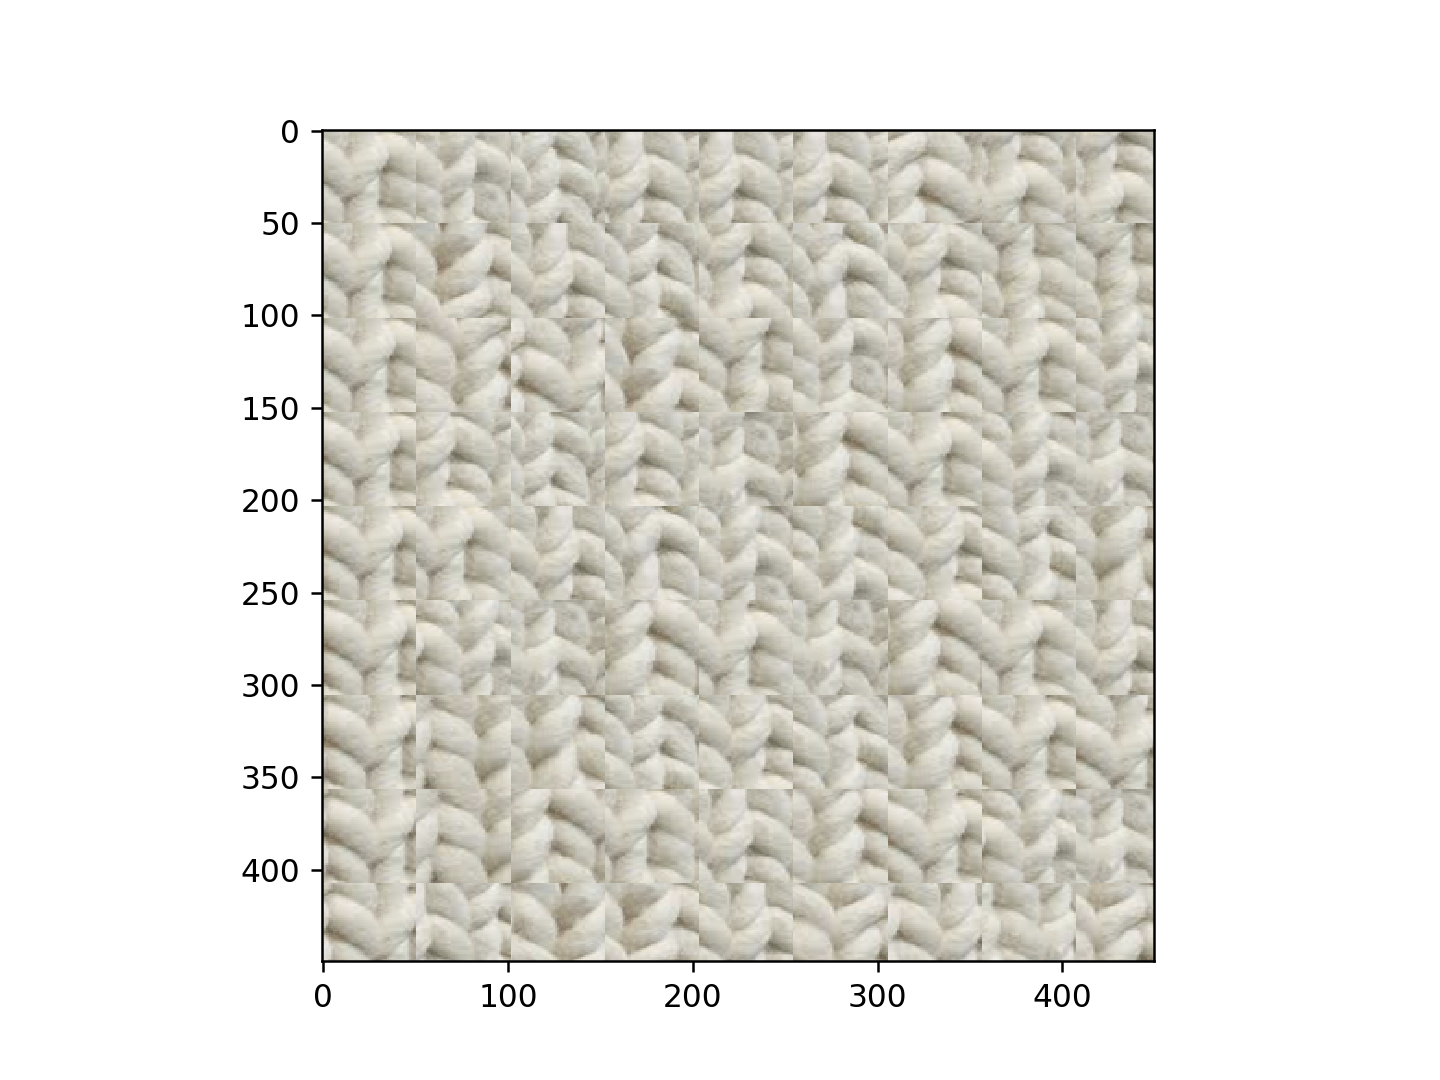

In [14]:
output = quilt_simple(sample_img, 500 , 51, int(51/4), 0.000001)
%matplotlib notebook
                      
plt.imshow(BGRtoRGB(output[:450, :450]))

### Part III: Seam Finding (20 pts)


In [15]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

# def choose_patch_prime(ssd, tol, patch_size):
#     minc = ssd.min()
#     minc = max(minc,1)
#     elm = np.argwhere(ssd < minc*(1+tol))
#     row = elm[0][0]
#     col = elm[0][1]
#     c = int(patch_size/2) + int(patch_size/6)
    
#     return row + c - int(patch_size/2) , col + c - int(patch_size/2)


In [16]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
#     """
#     Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
#     Feel free to add function parameters
#     :param sample: numpy.ndarray
#     :param out_size: int
#     :param patch_size: int
#     :param overlap: int
#     :param tol: float
#     :return: numpy.ndarray
#     """
    c = int(patch_size/2) + overlap
    output_image = np.zeros((out_size, out_size, 3), dtype=sample.dtype)

    generalMask = np.zeros((patch_size + overlap, patch_size + overlap,3) ,dtype=sample.dtype)
    colMask = np.zeros((patch_size +overlap, patch_size , 3) ,dtype=sample.dtype)
    rowMask = np.zeros((patch_size , patch_size +overlap, 3) ,dtype=sample.dtype)
    for i in range(0,overlap):
        rowMask[:, i] = 1
        generalMask[:,i] = 1
        generalMask[i,:] = 1
        colMask[i, :] = 1

    pre_computed_val_rowMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=rowMask)
    pre_computed_val_colMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=colMask)
    pre_computed_val_generalMask = cv2.filter2D(sample ** 2, ddepth=-1, kernel=generalMask)
    for i in range(0, int(out_size/patch_size) ):
        for j in range(0, int(out_size/patch_size) ):
            if i==0 and j==0:
                #get a rand block 
                rand_row = random.randint(0, sample.shape[0] - patch_size - 1)
                rand_col = random.randint(0, sample.shape[1] - patch_size - 1)
                
            elif i==0:
                T = output_image[:patch_size, j*patch_size - overlap:j*patch_size + patch_size]
                cost = SSD_match(T, rowMask, sample, pre_computed_val_rowMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c), :]

                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                overlap_old = output_image[: patch_size, j*patch_size - overlap: j*patch_size].copy()
                overlap_new = sample[rand_row : rand_row + patch_size, rand_col - overlap: rand_col].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum.T)
                overlap_new[:,:,0]= overlap_cut.T * overlap_new[:,:,0]
                overlap_new[:,:,1]= overlap_cut.T * overlap_new[:,:,1]
                overlap_new[:,:,2]= overlap_cut.T * overlap_new[:,:,2]
                overlap_cut = 1- overlap_cut
                overlap_old[:,:,0]= overlap_cut.T * overlap_old[:,:,0]
                overlap_old[:,:,1]= overlap_cut.T * overlap_old[:,:,1]
                overlap_old[:,:,2]= overlap_cut.T * overlap_old[:,:,2]
                
                output_image[i*patch_size: i*patch_size+patch_size , j*patch_size - overlap:j*patch_size] = overlap_old + overlap_new
            elif j==0:
                T = output_image[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                cost = SSD_match(T, colMask, sample, pre_computed_val_colMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c), :]

                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
                overlap_old = output_image[i*patch_size - overlap: i*patch_size, : patch_size].copy()
                overlap_new = sample[rand_row - overlap : rand_row , rand_col : rand_col + patch_size].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum)
                overlap_new[:,:,0]= overlap_cut * overlap_new[:,:,0]
                overlap_new[:,:,1]= overlap_cut * overlap_new[:,:,1]
                overlap_new[:,:,2]= overlap_cut * overlap_new[:,:,2]
                overlap_cut = 1- overlap_cut
                overlap_old[:,:,0]= overlap_cut * overlap_old[:,:,0]
                overlap_old[:,:,1]= overlap_cut * overlap_old[:,:,1]
                overlap_old[:,:,2]= overlap_cut * overlap_old[:,:,2]
                
                output_image[i*patch_size - overlap: i*patch_size , : patch_size] = overlap_old + overlap_new

            else:
                T = output_image[i*patch_size - overlap:i*patch_size + patch_size, j*patch_size - overlap:j*patch_size + patch_size]
                cost = SSD_match(T, generalMask, sample, pre_computed_val_generalMask) 
                cost_subset = cost[c:(cost.shape[0]-c), c:(cost.shape[1]-c), :]

                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)

                ###
                overlap_old = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                overlap_new = sample[rand_row - overlap : rand_row , rand_col - overlap : rand_col + patch_size].copy()
                square_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                square_new = sample[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col + patch_size].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum)
#                 if i==2 and j==2:
#                     return overlap_old, overlap_new, overlap_cut, ssd_sum
                top_mask = overlap_cut
                buttom_mask = np.ones((patch_size, patch_size + overlap),dtype=top_mask.dtype)
                agg_mask1 = np.vstack((top_mask, buttom_mask))              
                
                #####
                output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size] = overlap_old + overlap_new
                left_top_square_1 = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size]
                ####
                overlap_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size ].copy()
                overlap_new = sample[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col ].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum.T)
                overlap_cut = overlap_cut.T
                left_mask = overlap_cut
                right_mask = np.ones((patch_size + overlap, patch_size ),dtype=left_mask.dtype)
                agg_mask2 = np.hstack((left_mask, right_mask))
               
                agg_mask = np.bitwise_and(agg_mask1, agg_mask2)
                    
                square_new[:,:,0]= agg_mask * square_new[:,:,0]
                square_new[:,:,1]= agg_mask * square_new[:,:,1]
                square_new[:,:,2]= agg_mask * square_new[:,:,2]
                
                agg_mask = 1- agg_mask
                square_old[:,:,0]= agg_mask * square_old[:,:,0]
                square_old[:,:,1]= agg_mask * square_old[:,:,1]
                square_old[:,:,2]= agg_mask * square_old[:,:,2]
                
                output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size + patch_size] = square_old + square_new
                
                continue
                ####
            rand_patch = sample[rand_row : rand_row + patch_size, rand_col: rand_col + patch_size]
            output_image[i*patch_size:i*patch_size + rand_patch.shape[0], j*patch_size:j*patch_size + rand_patch.shape[1]] = rand_patch
            
    return output_image[:470, :470]

<IPython.core.display.Javascript object>


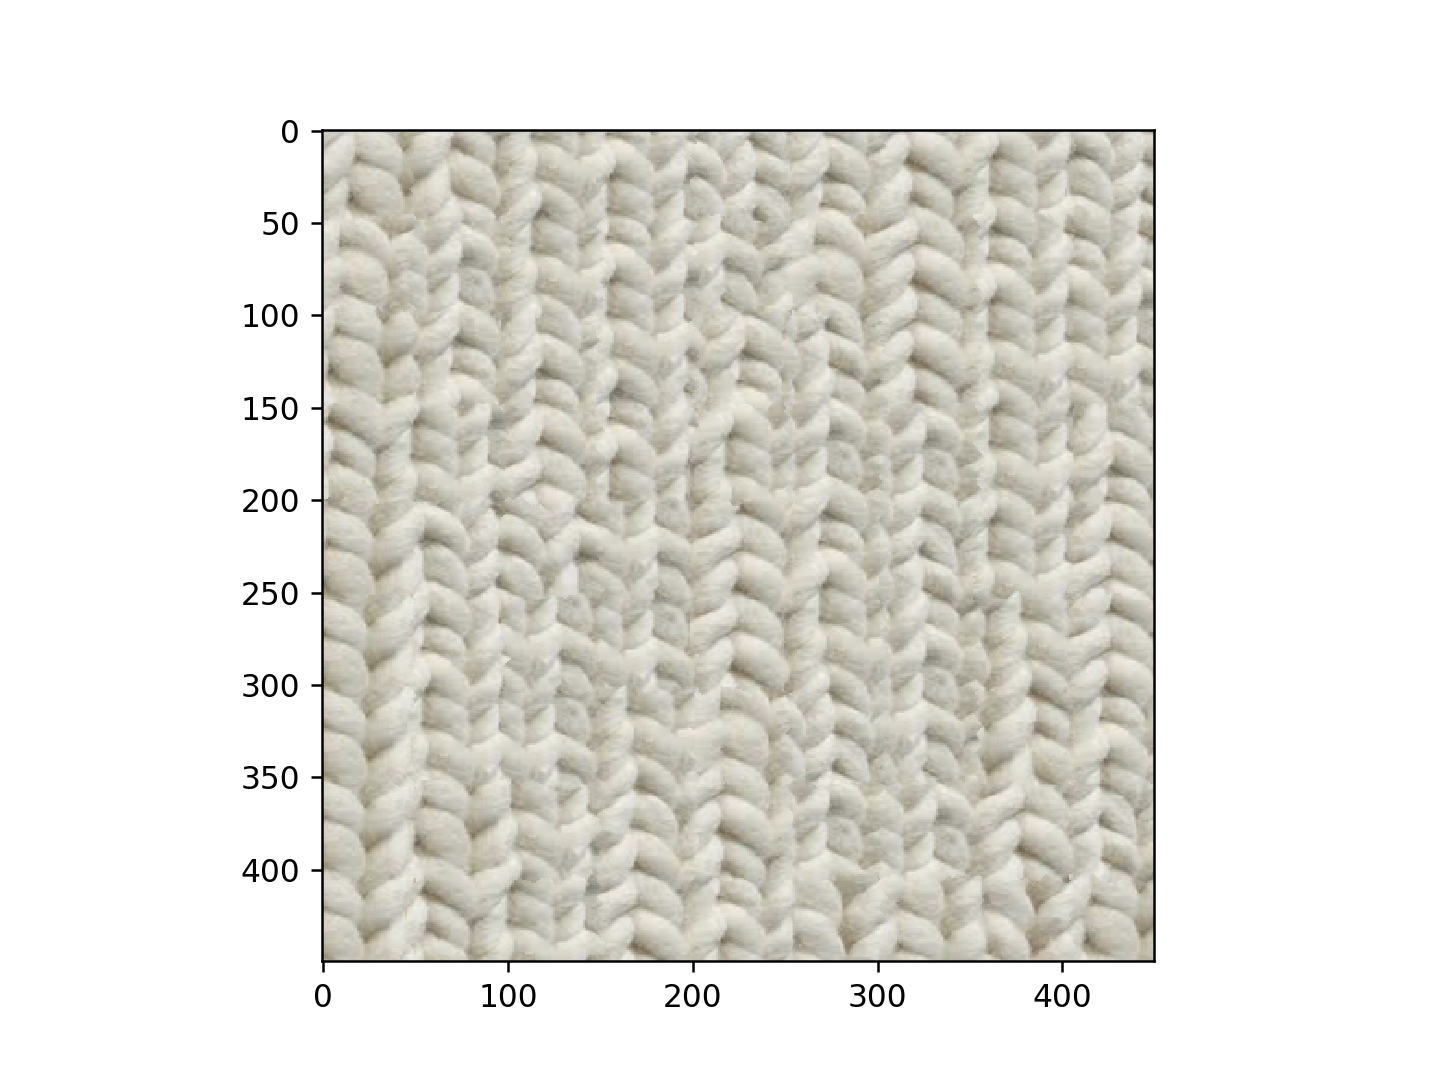

In [17]:
res= quilt_cut(sample_img, 500 , 51, int(51/8), 0.00001)
# if res:
%matplotlib notebook

plt.imshow(BGRtoRGB(res[:450, :450]))


### part IV: Texture Transfer (30 pts)

In [18]:
from scipy.ndimage.filters import gaussian_filter

# def choose_patch_third(ssd, tol, T):
#     minc = ssd.min()
#     minc = max(minc,1)
#     elm = np.argwhere(ssd < minc*(1+tol))
#     row = elm[0][0]
#     col = elm[0][1]
#     return row + 10 - int(T.shape[0]/2) , col + 10 - int(T.shape[1]/2)
def SSD_match_textureMatch(T, M, I):
    ssd =  - 2 * cv2.filter2D(I, ddepth=-1, kernel = T)  + ((T)**2).sum() + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd
    

In [19]:
def texture_transfer(sample_texture_color,sample_texture_gray, target_image_color, target_image_gray):
    """
    Feel free to add function parameters
    """
    patch_size = 31
    overlap = int(patch_size/6)    
    c = int(patch_size/2) + overlap
    tol = 0.00001
    alpha = 0.5
    output_image = np.zeros(target_image_color.shape, dtype=target_image_color.dtype)
    
    generalMask = np.zeros((patch_size + overlap, patch_size + overlap,3) ,dtype=sample_texture_color.dtype)
    colMask = np.zeros((patch_size +overlap, patch_size , 3) ,dtype=sample_texture_color.dtype)
    rowMask = np.zeros((patch_size , patch_size +overlap, 3) ,dtype=sample_texture_color.dtype)
    for i in range(0,overlap):
        rowMask[:, i] = 1
        generalMask[:,i] = 1
        generalMask[i,:] = 1
        colMask[i, :] = 1

    pre_computed_val_rowMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=rowMask)
    pre_computed_val_colMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=colMask)
    pre_computed_val_generalMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=generalMask)
    
    for i in range(0, int(output_image.shape[0]/patch_size) ):
        for j in range(0, int(output_image.shape[1]/patch_size) ):
            if i==0 and j==0:
                #get a rand block 
                rand_row = random.randint(0, sample_texture_color.shape[0] - patch_size - 1)
                rand_col = random.randint(0, sample_texture_color.shape[1] - patch_size - 1)
                
            elif i==0:
                patch1 = output_image[:patch_size, j*patch_size - overlap:j*patch_size + patch_size] 
                patch2 = target_image_gray[:patch_size, j*patch_size - overlap:j*patch_size + patch_size] #blured target patch
                
                cost1 = SSD_match(patch1, rowMask, sample_texture_color, pre_computed_val_rowMask) 
                cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3

#                 cost2 = SSD_match_textureMatch(patch2, rowMask, sample_texture_gray)

                cost2 = SSD_match_textureMatch(patch2, np.ones((rowMask.shape),dtype=rowMask.dtype ) , sample_texture_gray)
                
                cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
                overlap_old = output_image[: patch_size, j*patch_size - overlap: j*patch_size].copy()
                overlap_new = sample_texture_color[rand_row : rand_row + patch_size, rand_col - overlap: rand_col].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum.T)
                overlap_new[:,:,0]= overlap_cut.T * overlap_new[:,:,0]
                overlap_new[:,:,1]= overlap_cut.T * overlap_new[:,:,1]
                overlap_new[:,:,2]= overlap_cut.T * overlap_new[:,:,2]
                overlap_cut = 1- overlap_cut
                overlap_old[:,:,0]= overlap_cut.T * overlap_old[:,:,0]
                overlap_old[:,:,1]= overlap_cut.T * overlap_old[:,:,1]
                overlap_old[:,:,2]= overlap_cut.T * overlap_old[:,:,2]
                
                output_image[i*patch_size: i*patch_size+patch_size , j*patch_size - overlap:j*patch_size] = overlap_old + overlap_new
            elif j==0:
#                 continue
                patch1 = output_image[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                patch2 = target_image_gray[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                
                cost1 = SSD_match(patch1, colMask, sample_texture_color, pre_computed_val_colMask) 
                cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3
#                 cost2 = SSD_match_textureMatch(patch2, colMask , sample_texture_gray)
                
                cost2 = SSD_match_textureMatch(patch2, np.ones((colMask.shape),dtype=colMask.dtype ) , sample_texture_gray)
                cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )
 
                
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
                overlap_old = output_image[i*patch_size - overlap: i*patch_size, : patch_size].copy()
                overlap_new = sample_texture_color[rand_row - overlap : rand_row , rand_col : rand_col + patch_size].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum)
                overlap_new[:,:,0]= overlap_cut * overlap_new[:,:,0]
                overlap_new[:,:,1]= overlap_cut * overlap_new[:,:,1]
                overlap_new[:,:,2]= overlap_cut * overlap_new[:,:,2]
                overlap_cut = 1- overlap_cut
                overlap_old[:,:,0]= overlap_cut * overlap_old[:,:,0]
                overlap_old[:,:,1]= overlap_cut * overlap_old[:,:,1]
                overlap_old[:,:,2]= overlap_cut * overlap_old[:,:,2]
                
                output_image[i*patch_size - overlap: i*patch_size , : patch_size] = overlap_old + overlap_new

            else:
                patch1 = output_image[(i*patch_size - overlap):(i*patch_size + patch_size), (j*patch_size - overlap):(j*patch_size + patch_size)]
                patch2 = target_image_gray[(i*patch_size - overlap):(i*patch_size + patch_size),(j*patch_size - overlap):(j*patch_size + patch_size)]
                
                cost1 = SSD_match(patch1, generalMask, sample_texture_color, pre_computed_val_generalMask) 
                cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3
#                 cost2 = SSD_match_textureMatch(patch2, generalMask , sample_texture_gray)
                
                cost2 = SSD_match_textureMatch(patch2, np.ones((generalMask.shape),dtype=generalMask.dtype ) , sample_texture_gray)
                cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )
 
                rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)
                
                ###
                overlap_old = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                overlap_new = sample_texture_color[rand_row - overlap : rand_row , rand_col - overlap : rand_col + patch_size].copy()
                square_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                square_new = sample_texture_color[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col + patch_size].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum)
                
                top_mask = overlap_cut
                buttom_mask = np.ones((patch_size, patch_size + overlap),dtype=top_mask.dtype)
                agg_mask1 = np.vstack((top_mask, buttom_mask))              
                
                #####
                output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size] = overlap_old + overlap_new
                left_top_square_1 = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size]
                ####
                overlap_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size ].copy()
                overlap_new = sample_texture_color[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col ].copy()
                
                ssd_overlap = (overlap_old - overlap_new)**2
                ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                overlap_cut = utils.cut(ssd_sum.T)
                overlap_cut = overlap_cut.T
                left_mask = overlap_cut
                right_mask = np.ones((patch_size + overlap, patch_size ),dtype=left_mask.dtype)
                agg_mask2 = np.hstack((left_mask, right_mask))
                
                agg_mask = np.bitwise_and(agg_mask1, agg_mask2)
                    
                square_new[:,:,0]= agg_mask * square_new[:,:,0]
                square_new[:,:,1]= agg_mask * square_new[:,:,1]
                square_new[:,:,2]= agg_mask * square_new[:,:,2]
                
                agg_mask = 1- agg_mask
                square_old[:,:,0]= agg_mask * square_old[:,:,0]
                square_old[:,:,1]= agg_mask * square_old[:,:,1]
                square_old[:,:,2]= agg_mask * square_old[:,:,2]
                
                output_image[(i*patch_size - overlap): (i*patch_size + patch_size), (j*patch_size - overlap): (j*patch_size + patch_size)] = square_old + square_new
                
                continue
                ####
            rand_patch = sample_texture_color[rand_row : rand_row + patch_size, rand_col: rand_col + patch_size]
            output_image[i*patch_size:(i*patch_size + rand_patch.shape[0]), j*patch_size:(j*patch_size + rand_patch.shape[1])] = rand_patch
            
    return output_image
    pass

<IPython.core.display.Javascript object>


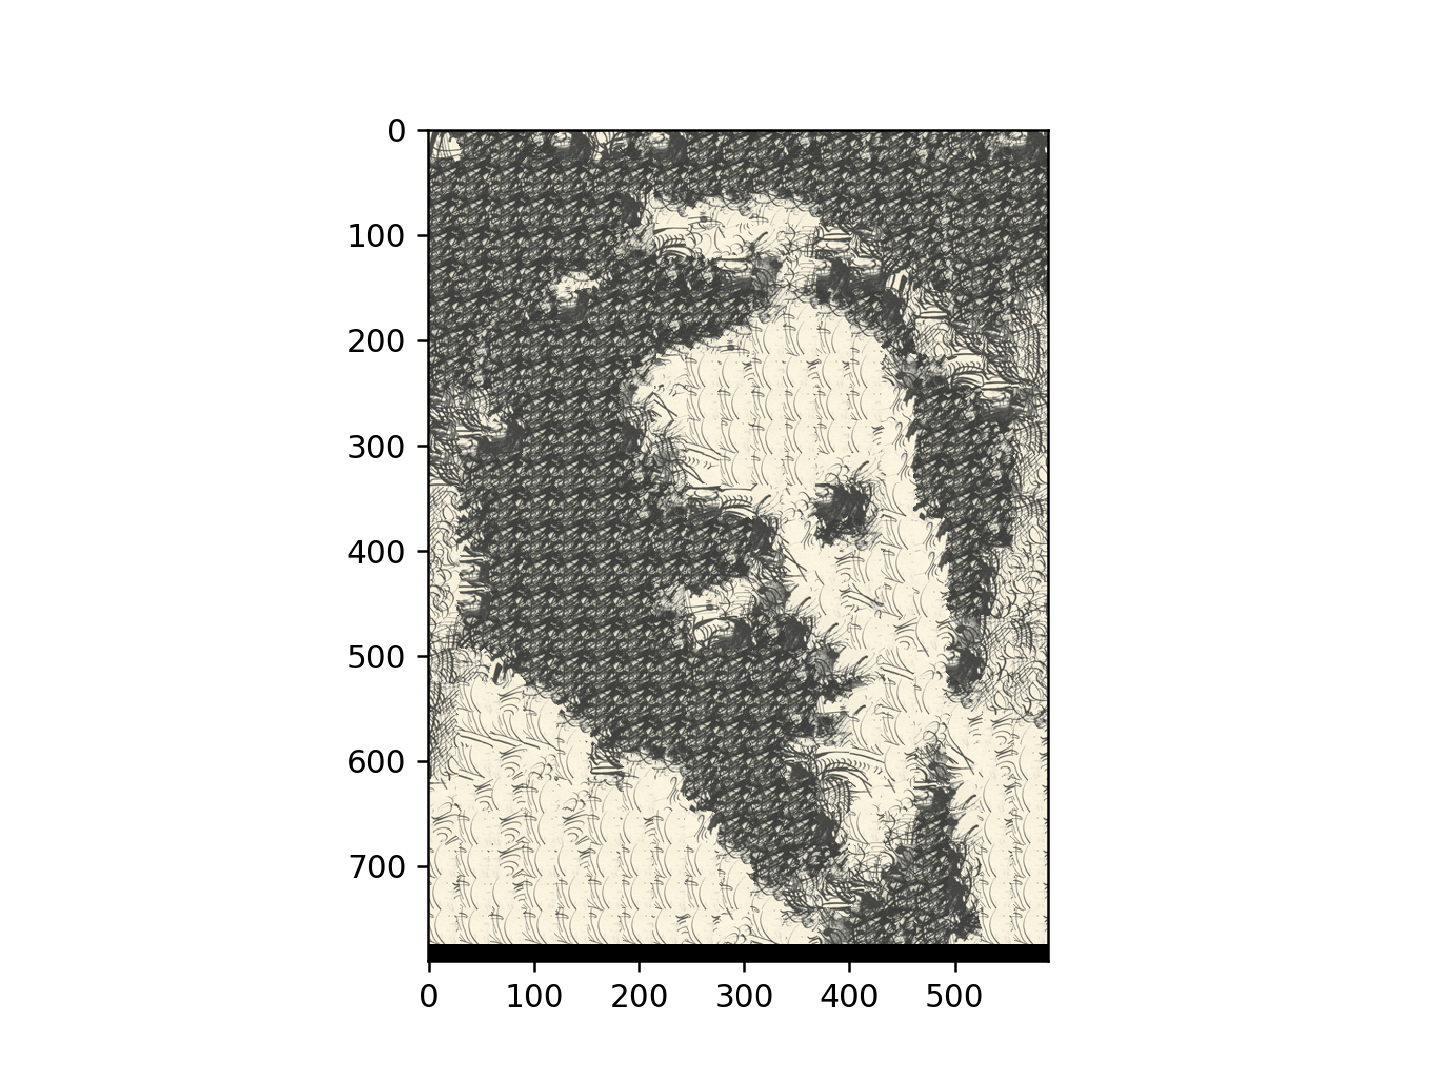

In [20]:
sample_texture_color = cv2.imread("samples/sketch.tiff")/255
sample_texture_gray = cv2.imread("samples/sketch.tiff", 0)/255
target_image_color = cv2.imread("samples/feynman.jpg")/255
target_image_gray = cv2.imread("samples/feynman.jpg", 0)/255

target_image_gray = gaussian_filter(target_image_gray, sigma=2)
sample_texture_gray = gaussian_filter(sample_texture_gray, sigma=2)

res = texture_transfer(sample_texture_color[50:-50, 50:-50],sample_texture_gray[50:-50, 50:-50], target_image_color, target_image_gray)
%matplotlib notebook

new = np.zeros(res.shape, dtype=res.dtype)
new[:,:,0] = res[:,:,2]
new[:,:,1] = res[:,:,1]
new[:,:,2] = res[:,:,0]

plt.imshow(new)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [21]:
def iterative_texture_transfer(sample_texture_color,sample_texture_gray, target_image_color, target_image_gray):
    """
    Feel free to add function parameters
    """
    patch_size = 71
    overlap = int(patch_size/6)    
    c = int(patch_size/2) + overlap
    tol = 0.00001
    alpha = 0.3
    
    image_lst = []
    N= 5
    for z in range(0,N):
        patch_size = int(2*patch_size/3)
        overlap = int(patch_size/6)    
        c = int(patch_size/2) + overlap
        
        output_image = np.zeros(target_image_color.shape, dtype=target_image_color.dtype)
    
        generalMask = np.zeros((patch_size + overlap, patch_size + overlap,3) ,dtype=sample_texture_color.dtype)
        colMask = np.zeros((patch_size +overlap, patch_size , 3) ,dtype=sample_texture_color.dtype)
        rowMask = np.zeros((patch_size , patch_size +overlap, 3) ,dtype=sample_texture_color.dtype)
        for i in range(0,overlap):
            rowMask[:, i] = 1
            generalMask[:,i] = 1
            generalMask[i,:] = 1
            colMask[i, :] = 1

        pre_computed_val_rowMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=rowMask)
        pre_computed_val_colMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=colMask)
        pre_computed_val_generalMask = cv2.filter2D(sample_texture_color ** 2, ddepth=-1, kernel=generalMask)
        alpha = (0.8*(z)/(N-1)) + 0.1
        print(alpha, patch_size)
        for i in range(0, int(output_image.shape[0]/patch_size) ):
            for j in range(0, int(output_image.shape[1]/patch_size) ):
                if i==0 and j==0:
                    #get a rand block 
                    rand_row = random.randint(0, sample_texture_color.shape[0] - patch_size - 1)
                    rand_col = random.randint(0, sample_texture_color.shape[1] - patch_size - 1)

                elif i==0:
                    patch1 = output_image[:patch_size, j*patch_size - overlap:j*patch_size + patch_size] 
                    patch2 = target_image_gray[:patch_size, j*patch_size - overlap:j*patch_size + patch_size] #blured target patch

                    cost1 = SSD_match(patch1, rowMask, sample_texture_color, pre_computed_val_rowMask) 
                    if z != 0:
                        patch3 = image_lst[z-1][:patch_size, j*patch_size - overlap:j*patch_size + patch_size]
                        cost3 = SSD_match_textureMatch(patch3, np.ones((rowMask.shape),dtype=rowMask.dtype ) , sample_texture_color)
                        cost1 += cost3
                    cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3
                

                    cost2 = SSD_match_textureMatch(patch2, np.ones((rowMask.shape),dtype=rowMask.dtype ) , sample_texture_gray)
                    
                    
                    cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )
                    rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)

                    overlap_old = output_image[: patch_size, j*patch_size - overlap: j*patch_size].copy()
                    overlap_new = sample_texture_color[rand_row : rand_row + patch_size, rand_col - overlap: rand_col].copy()

                    ssd_overlap = (overlap_old - overlap_new)**2
                    ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                    overlap_cut = utils.cut(ssd_sum.T)
                    overlap_new[:,:,0]= overlap_cut.T * overlap_new[:,:,0]
                    overlap_new[:,:,1]= overlap_cut.T * overlap_new[:,:,1]
                    overlap_new[:,:,2]= overlap_cut.T * overlap_new[:,:,2]
                    overlap_cut = 1- overlap_cut
                    overlap_old[:,:,0]= overlap_cut.T * overlap_old[:,:,0]
                    overlap_old[:,:,1]= overlap_cut.T * overlap_old[:,:,1]
                    overlap_old[:,:,2]= overlap_cut.T * overlap_old[:,:,2]

                    output_image[i*patch_size: i*patch_size+patch_size , j*patch_size - overlap:j*patch_size] = overlap_old + overlap_new
                elif j==0:
#                     continue
                    patch1 = output_image[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                    patch2 = target_image_gray[i*patch_size - overlap:i*patch_size + patch_size,:patch_size]

                    cost1 = SSD_match(patch1, colMask, sample_texture_color, pre_computed_val_colMask) 
                    if z != 0:
                        patch3 = image_lst[z-1][i*patch_size - overlap:i*patch_size + patch_size,:patch_size]
                        cost3 = SSD_match_textureMatch(patch3, np.ones((rowMask.shape),dtype=rowMask.dtype ) , sample_texture_color)
                        cost1 += cost3
            
                    cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3

                    cost2 = SSD_match_textureMatch(patch2, np.ones((colMask.shape),dtype=colMask.dtype ) , sample_texture_gray)
                    cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )


                    rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)

                    overlap_old = output_image[i*patch_size - overlap: i*patch_size, : patch_size].copy()
                    overlap_new = sample_texture_color[rand_row - overlap : rand_row , rand_col : rand_col + patch_size].copy()

                    ssd_overlap = (overlap_old - overlap_new)**2
                    ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                    overlap_cut = utils.cut(ssd_sum)
                    overlap_new[:,:,0]= overlap_cut * overlap_new[:,:,0]
                    overlap_new[:,:,1]= overlap_cut * overlap_new[:,:,1]
                    overlap_new[:,:,2]= overlap_cut * overlap_new[:,:,2]
                    overlap_cut = 1- overlap_cut
                    overlap_old[:,:,0]= overlap_cut * overlap_old[:,:,0]
                    overlap_old[:,:,1]= overlap_cut * overlap_old[:,:,1]
                    overlap_old[:,:,2]= overlap_cut * overlap_old[:,:,2]

                    output_image[i*patch_size - overlap: i*patch_size , : patch_size] = overlap_old + overlap_new

                else:
#                     continue
                    patch1 = output_image[(i*patch_size - overlap):(i*patch_size + patch_size), (j*patch_size - overlap):(j*patch_size + patch_size)]
                    patch2 = target_image_gray[(i*patch_size - overlap):(i*patch_size + patch_size),(j*patch_size - overlap):(j*patch_size + patch_size)]

                    cost1 = SSD_match(patch1, generalMask, sample_texture_color, pre_computed_val_generalMask) 
                    if z != 0:
                        patch3 = image_lst[z-1][(i*patch_size - overlap):(i*patch_size + patch_size), (j*patch_size - overlap):(j*patch_size + patch_size)]
                        cost3 = SSD_match_textureMatch(patch3, np.ones((rowMask.shape),dtype=rowMask.dtype ) , sample_texture_color)
                        cost1 += cost3
                        
                    cost11 = (cost1[:,:,0] +cost1[:,:,1]+cost1[:,:,2])/3

                    cost2 = SSD_match_textureMatch(patch2, np.ones((generalMask.shape),dtype=generalMask.dtype ) , sample_texture_gray)
                    cost_subset =(alpha* cost11[c:(cost11.shape[0]-c), c:(cost11.shape[1]-c)]) + ((1-alpha)*cost2[c:(cost2.shape[0]-c), c:(cost2.shape[1]-c)] )

                    rand_row, rand_col = choose_patch(cost_subset, tol, patch_size)

                    ###
                    overlap_old = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                    overlap_new = sample_texture_color[rand_row - overlap : rand_row , rand_col - overlap : rand_col + patch_size].copy()
                    square_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size + patch_size].copy()
                    square_new = sample_texture_color[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col + patch_size].copy()

                    ssd_overlap = (overlap_old - overlap_new)**2
                    ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                    overlap_cut = utils.cut(ssd_sum)

                    top_mask = overlap_cut
                    buttom_mask = np.ones((patch_size, patch_size + overlap),dtype=top_mask.dtype)
                    agg_mask1 = np.vstack((top_mask, buttom_mask))              

                    #####
                    output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size + patch_size] = overlap_old + overlap_new
                    left_top_square_1 = output_image[i*patch_size - overlap: i*patch_size, j*patch_size - overlap: j*patch_size]
                    ####
                    overlap_old = output_image[i*patch_size - overlap: i*patch_size + patch_size, j*patch_size - overlap: j*patch_size ].copy()
                    overlap_new = sample_texture_color[rand_row - overlap : rand_row + patch_size , rand_col - overlap : rand_col ].copy()

                    ssd_overlap = (overlap_old - overlap_new)**2
                    ssd_sum = ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2]
                    overlap_cut = utils.cut(ssd_sum.T)
                    overlap_cut = overlap_cut.T
                    left_mask = overlap_cut
                    right_mask = np.ones((patch_size + overlap, patch_size ),dtype=left_mask.dtype)
                    agg_mask2 = np.hstack((left_mask, right_mask))

                    agg_mask = np.bitwise_and(agg_mask1, agg_mask2)

                    square_new[:,:,0]= agg_mask * square_new[:,:,0]
                    square_new[:,:,1]= agg_mask * square_new[:,:,1]
                    square_new[:,:,2]= agg_mask * square_new[:,:,2]

                    agg_mask = 1- agg_mask
                    square_old[:,:,0]= agg_mask * square_old[:,:,0]
                    square_old[:,:,1]= agg_mask * square_old[:,:,1]
                    square_old[:,:,2]= agg_mask * square_old[:,:,2]

                    output_image[(i*patch_size - overlap): (i*patch_size + patch_size), (j*patch_size - overlap): (j*patch_size + patch_size)] = square_old + square_new

                    continue
                    ####
                rand_patch = sample_texture_color[rand_row : rand_row + patch_size, rand_col: rand_col + patch_size]
                output_image[i*patch_size:(i*patch_size + rand_patch.shape[0]), j*patch_size:(j*patch_size + rand_patch.shape[1])] = rand_patch

        image_lst.append(output_image)
    return image_lst      



0.1 47
0.30000000000000004 31
0.5 20
0.7000000000000001 13
0.9 8
third iteration:


<IPython.core.display.Javascript object>


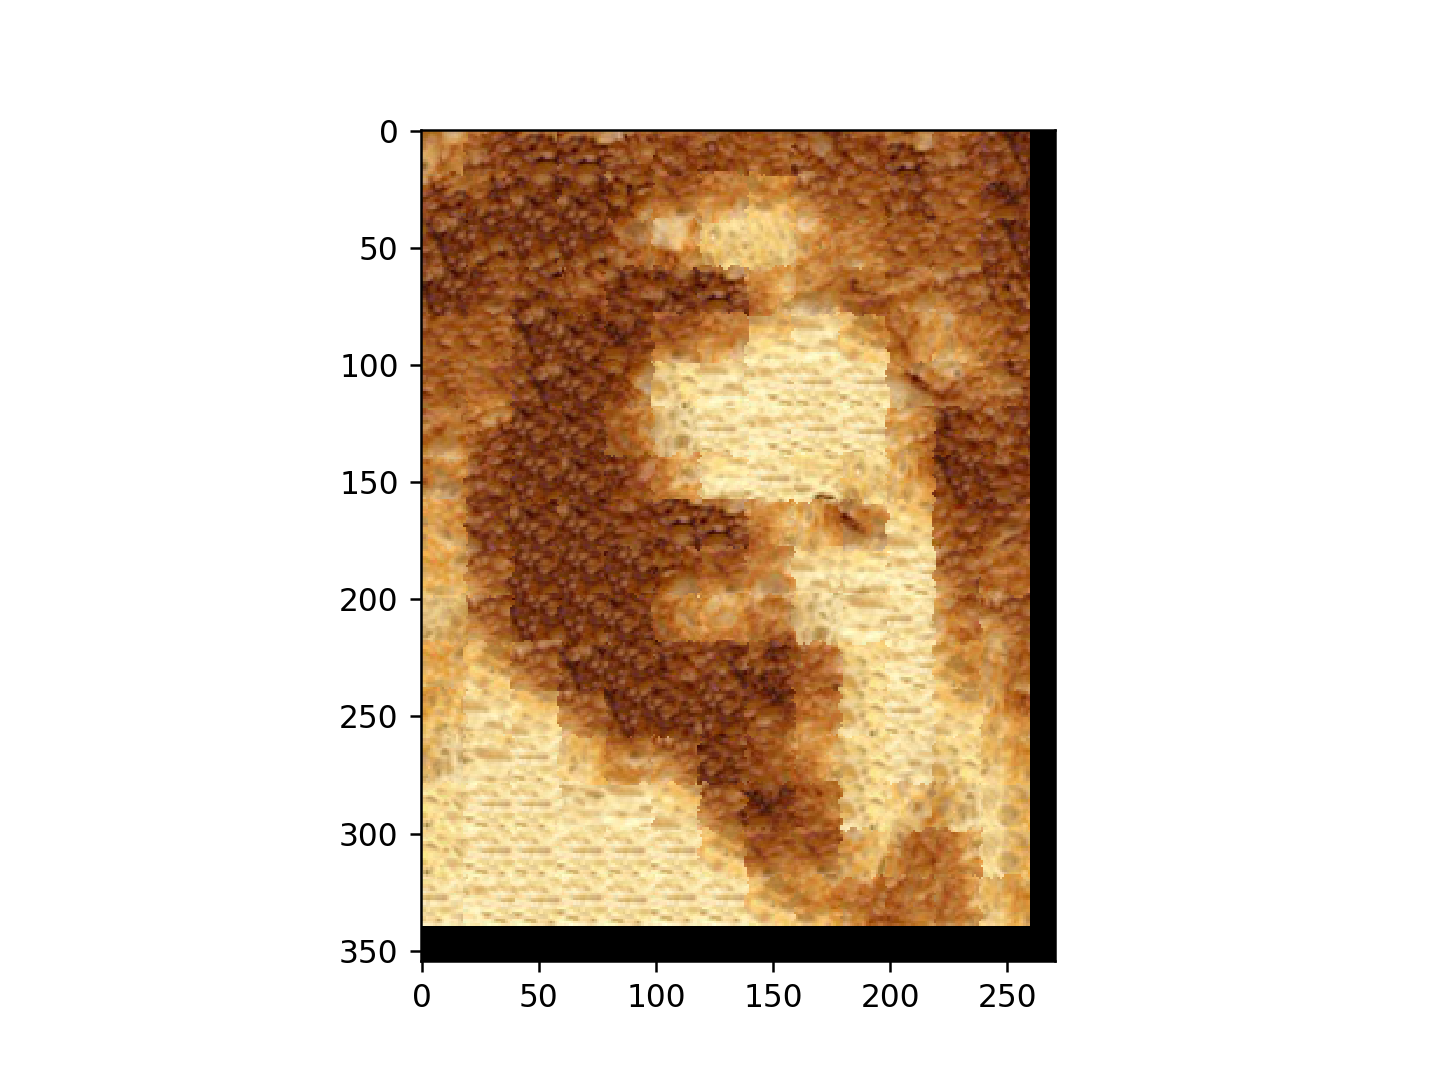

In [23]:
sample_texture_color = cv2.imread("samples/toast.jpg")/255
sample_texture_gray = cv2.imread("samples/toast.jpg", 0)/255
target_image_color = cv2.imread("samples/feynman.tiff")/255
target_image_gray = cv2.imread("samples/feynman.tiff", 0)/255

target_image_gray = gaussian_filter(target_image_gray, sigma=2)
sample_texture_gray = gaussian_filter(sample_texture_gray, sigma=2)

lst = iterative_texture_transfer(sample_texture_color[50:-50, 50:-50],sample_texture_gray[50:-50, 50:-50], target_image_color, target_image_gray)
%matplotlib notebook
print("third iteration:")
res = lst[2]
new = np.zeros(res.shape, dtype=res.dtype)
new[:,:,0] = res[:,:,2]
new[:,:,1] = res[:,:,1]
new[:,:,2] = res[:,:,0]

plt.imshow(new)

fifth iteration


<IPython.core.display.Javascript object>


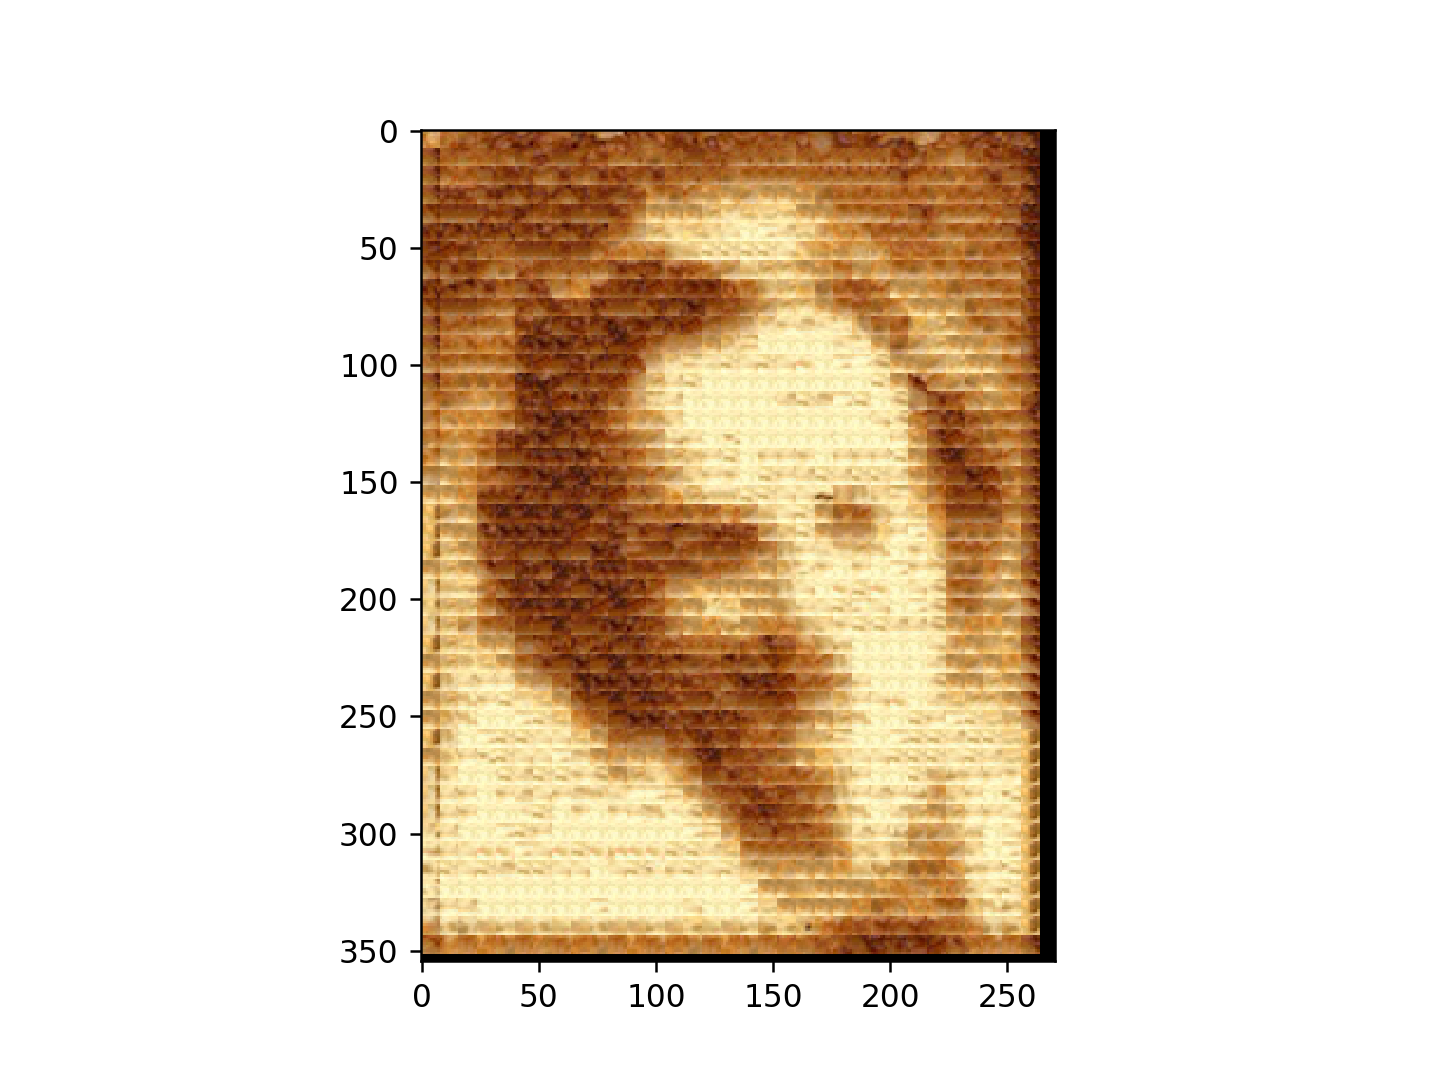

In [24]:
%matplotlib notebook
res = lst[4]
new = np.zeros(res.shape, dtype=res.dtype)
new[:,:,0] = res[:,:,2]
new[:,:,1] = res[:,:,1]
new[:,:,2] = res[:,:,0]
print("fifth iteration")
plt.imshow(new)

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(759, 1342) (759, 1342, 3) (759, 1342, 3)


<IPython.core.display.Javascript object>


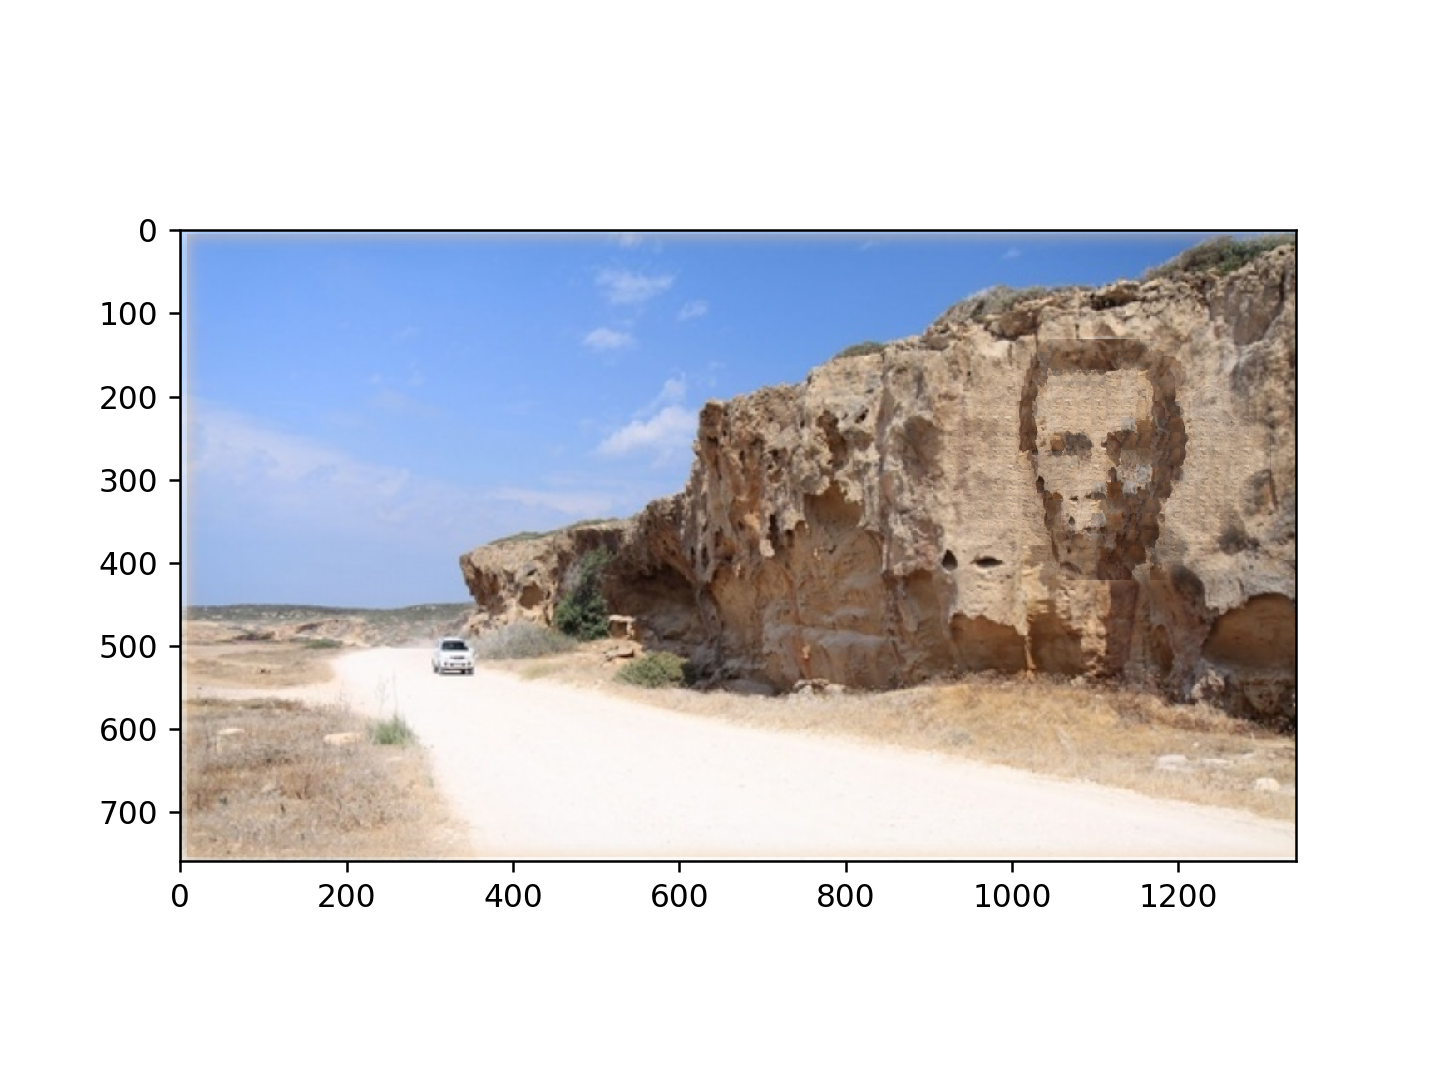

In [25]:
mask1 = (cv2.imread("samples/mountMask.JPG", 0)/255)[:759, :1342]
angel_bread = (cv2.imread("samples/linlin.jpg")/255)[:759, :1342, :]
bread = (cv2.imread("samples/mountView.jpg")/255)[:759, :1342, :]
print(mask1.shape, angel_bread.shape, bread.shape)

mask1 = gaussian_filter(mask1, sigma=10)
x = np.zeros(angel_bread.shape, dtype=angel_bread.dtype)
x[:,:,0] = mask1*angel_bread[:,:,2]
x[:,:,1] = mask1*angel_bread[:,:,1]
x[:,:,2] = mask1*angel_bread[:,:,0]
mask1 = 1-mask1
y = np.zeros(angel_bread.shape, dtype=angel_bread.dtype)

y[:,:,0] = mask1*bread[:,:,2]
y[:,:,1] = mask1*bread[:,:,1]
y[:,:,2] = mask1*bread[:,:,0]

%matplotlib notebook
plt.imshow(x+y, cmap='gray')

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).